In [ ]:
import pandas as pd
import numpy as np 


In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet


     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 184kB 7.1MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639787 sha256=b4850115585aaefc036dc68d3188f18ba40c9d50aa5fb76564415976c7e85f69
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/xxiang27/sikkaAIHackathon/main/data_file.csv')
df.head()

,id,month,year,visits,no_of_appts,production
0,34,3,2014,1,960,76.55
1,34,4,2014,488,1089,106333.80
2,34,5,2014,831,993,192230.40
3,34,6,2014,753,884,163515.12
4,34,7,2014,721,797,160185.90


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27170 entries, 0 to 27169
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           27170 non-null  int64  
 1   month        27170 non-null  int64  
 2   year         27170 non-null  int64  
 3   visits       27170 non-null  int64  
 4   no_of_appts  27170 non-null  int64  
 5   production   27170 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 1.2 MB


In [ ]:
df.describe()

,id,month,year,visits,no_of_appts,production
count,27170.000000,27170.000000,27170.000000,27170.000000,27170.000000,2.717000e+04
mean,141.936069,6.582149,2015.817372,567.629923,272.300184,1.810539e+05
std,81.682146,3.457194,3.018620,380.785944,380.348904,1.340010e+05
min,1.000000,1.000000,2010.000000,1.000000,1.000000,-1.592922e+05
25%,73.000000,4.000000,2013.000000,321.000000,18.000000,9.867377e+04
50%,143.000000,7.000000,2016.000000,479.000000,144.000000,1.498361e+05
75%,210.000000,10.000000,2018.000000,724.000000,403.000000,2.239591e+05
max,284.000000,12.000000,2020.000000,3229.000000,4147.000000,1.230910e+06


In [ ]:
def turntoDate(df):
  lst = []
  for i in range(len(df)):
    lst.append(pd.Timestamp(year = df.loc[i, 'year'], month = df.loc[i, 'month'], day=None))
  df['date'] = lst
  return df

In [ ]:
df['day'] = 15
dates = pd.to_datetime(df[['month', 'year','day']].copy())
dates.head()

0   2014-03-15
1   2014-04-15
2   2014-05-15
3   2014-06-15
4   2014-07-15
dtype: datetime64[ns]

In [ ]:
df_final = pd.concat([dates, df],axis=1)
df_final = df_final.drop(columns = ['month', 'year', 'day'])
df_final.head()

,0,id,visits,no_of_appts,production
0,2014-03-15,34,1,960,76.55
1,2014-04-15,34,488,1089,106333.80
2,2014-05-15,34,831,993,192230.40
3,2014-06-15,34,753,884,163515.12
4,2014-07-15,34,721,797,160185.90


In [ ]:
# separate dataframe into separate dataframes for each practice 

import math 

def separate(df):
  '''takes a dataframe returns a list of dataframes, 
  one for each unique value under the id column'''
  lst = []
  grouped = df.groupby(df.id)
  for i in range(1, 285):
    lst.append(grouped.get_group(i))
  return lst 

def train_test_split(lst, percent):
  '''takes a list of dataframes and returns the time series train and test split based on the percent'''
  test_set = []
  for df in lst:
    add_test = math.floor(len(df) * percent)
    df_add = df.tail(add_test).copy()
    test_set.append(df_add)
    df.drop(df.tail(add_test).index, inplace = True)
  df_train = pd.concat(lst, ignore_index=True)
  df_test = pd.concat(test_set, ignore_index = True)
  return df_train, df_test
  



In [ ]:
train_lst = separate(df_final)
df_train, df_test = train_test_split(train_lst, 0.2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
import sklearn
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Convert DataFrame to matrix
mat = df.values
# Using sklearn
km = sklearn.cluster.KMeans(n_clusters=5)
km.fit(mat)

# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([df.index,labels]).T

results.head()

,0,1
0,0,2
1,1,2
2,2,0
3,3,0
4,4,0


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
 
df_transformed = df.drop(columns=['id', 'day'])
df_transformed.head()

,month,year,visits,no_of_appts,production
0,3,2014,1,960,76.55
1,4,2014,488,1089,106333.80
2,5,2014,831,993,192230.40
3,6,2014,753,884,163515.12
4,7,2014,721,797,160185.90


[0 0 2 ... 0 0 0]
[[-1.80977021e+05  9.46190990e+02]
 [-7.47188296e+04  9.29729211e+02]
 [-6.19898461e+04  8.55731161e+02]
 ...
 [-7.67214746e+04  1.45492122e+02]
 [-7.67402842e+04  1.33735701e+02]
 [-9.86106813e+04  1.89153882e+02]]


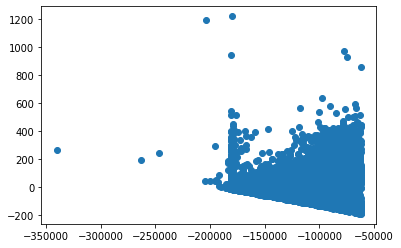

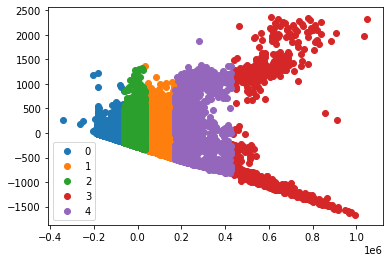

In [ ]:
#Transform the data
df_transformed = pca.fit_transform(df_transformed)
 
df_transformed.shape

#Initialize the class object
kmeans = KMeans(n_clusters= 5)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df_transformed)
 
print(label)
 
#filter rows of original data
filtered_label0 = df_transformed[label == 0]

print(filtered_label0)
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df_transformed[label == i , 0] , df_transformed[label == i , 1] , label = i)
plt.legend()
plt.show()

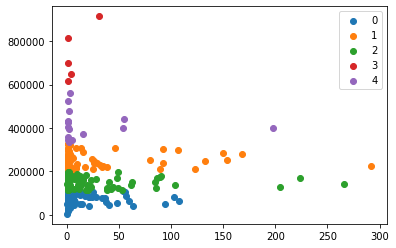

In [ ]:
practice_pts = []
for practice in train_lst:
  practice_pt = []
  practice_pt.append(practice['visits'].mean() / practice['no_of_appts'].mean())
  practice_pt.append(practice['production'].mean())
  practice_pts.append(practice_pt)

practice_pts_data = np.array(practice_pts)

#Initialize the class object
kmeans = KMeans(n_clusters= 5)
 
#predict the labels of clusters.
label = kmeans.fit_predict(practice_pts_data)
 
# print(label)

# SINGLE CLUSTER 
# #filter rows of original data
# filtered_label0 = practice_pts_data[label == 0]

# # print(filtered_label0)
 
# #plotting the results
# plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
# plt.show()

# ALL CLUSTERS
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(practice_pts_data[label == i , 0] , practice_pts_data[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
df_final = train_lst[0]
only_prod = df_final.drop(columns = ['id', 'visits', 'no_of_appts'])
only_prod = only_prod.rename(columns={0: "ds", "production": "y"})
only_prod.head()

,ds,y
10524,2016-10-15,1854.70
10525,2016-11-15,11352.45
10526,2016-12-15,17854.65
10527,2017-01-15,11869.50
10528,2017-02-15,15596.90


In [ ]:
only_visits = df_final.drop(columns = ['id', 'no_of_appts', 'production'])
only_visits = only_visits.rename(columns={0: "ds", "visits": "y"})
only_visits.head()

,ds,y
10524,2016-10-15,4
10525,2016-11-15,31
10526,2016-12-15,40
10527,2017-01-15,27
10528,2017-02-15,41


In [ ]:
only_appts = df_final.drop(columns = ['id', 'visits', 'production'])
only_appts = only_appts.rename(columns={0: "ds", "production": "y"})
only_appts.head()

,ds,no_of_appts
10524,2016-10-15,4
10525,2016-11-15,32
10526,2016-12-15,54
10527,2017-01-15,39
10528,2017-02-15,57


In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


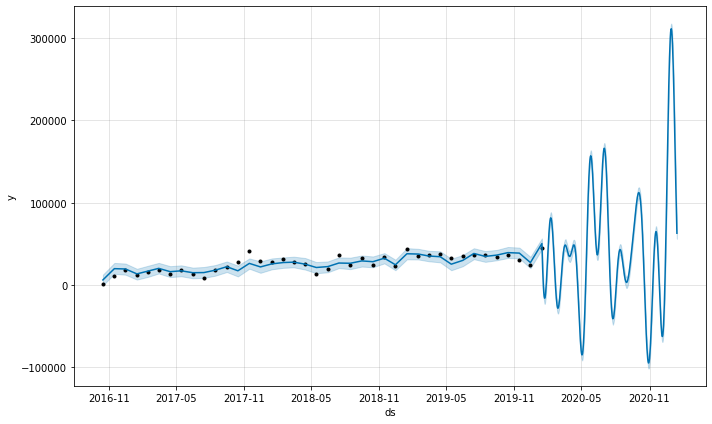

In [ ]:
m = Prophet()
m.fit(only_prod)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

plot_plotly(m, forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


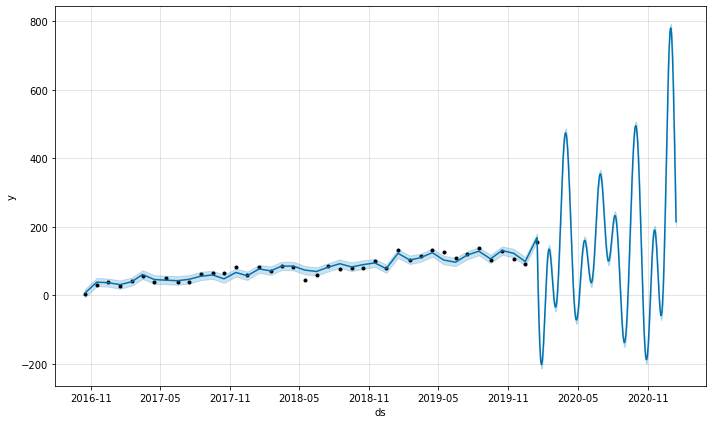

In [ ]:
n = Prophet()
n.fit(only_visits)

future_visits = n.make_future_dataframe(periods=365)
future_visits.tail()

forecast_visits = n.predict(future_visits)
forecast_visits[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1_visits = n.plot(forecast_visits)

plot_plotly(n, forecast_visits)

In [ ]:
forecast_visits.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
400,2021-01-10,164.989428,434.283631,458.010486,164.989426,164.989430,281.087257,281.087257,281.087257,281.087257,281.087257,281.087257,0.0,0.0,0.0,446.076685
401,2021-01-11,165.076513,376.644122,399.970419,165.076511,165.076514,223.717511,223.717511,223.717511,223.717511,223.717511,223.717511,0.0,0.0,0.0,388.794024
402,2021-01-12,165.163597,317.517344,342.811001,165.163595,165.163599,165.275770,165.275770,165.275770,165.275770,165.275770,165.275770,0.0,0.0,0.0,330.439367
403,2021-01-13,165.250682,260.609380,283.565344,165.250680,165.250683,106.693641,106.693641,106.693641,106.693641,106.693641,106.693641,0.0,0.0,0.0,271.944323
404,2021-01-14,165.337766,202.316839,227.115115,165.337764,165.337768,48.888213,48.888213,48.888213,48.888213,48.888213,48.888213,0.0,0.0,0.0,214.225979
